# Step #1 Generate Artificial Time Series Data

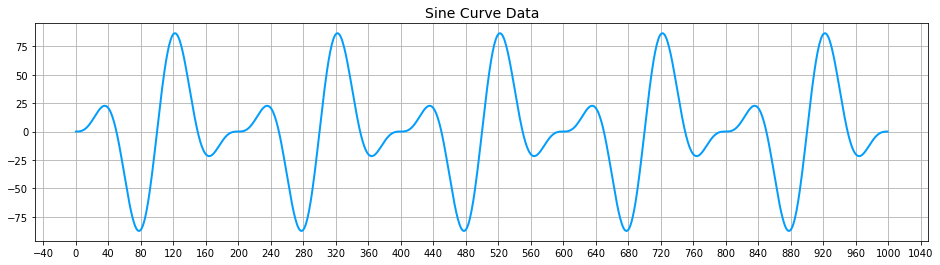

In [9]:
# Setting up packages for data manipulation and machine learning
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl 
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, TimeDistributed, Dropout, Activation

# Creating the sample sinus curve dataset
steps = 1000; gradient = 0.002
list_a = []
for i in range(0, steps, 1):
    y = 100 * round(math.sin(math.pi * i * 0.02 + 0.01), 4) * round(math.sin(math.pi * i * 0.005 + 0.01), 4) * round(math.sin(math.pi * i * 0.005 + 0.01), 4)
    list_a.append(y)
df = pd.DataFrame({"valid": list_a}, columns=["valid"])

# Visualizing the data
fig, ax1 = plt.subplots(figsize=(16, 4))
ax1.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.title("Sine Curve Data", fontsize=14)
plt.plot(df[["valid"]], color="#039dfc", linewidth=2.0)
plt.grid()
plt.show()

# Step #2 Preparing the Data 

In [10]:
# Settings
epochs = 4; batch_size = 1; sequencelength = 15; n_features = 1

# Get the number of rows to train the model on 80% of the data
npdataset = df.values
training_data_length = math.ceil(len(npdataset) * 0.6)

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = mmscaler.fit_transform(npdataset)

# Create a scaled training data set
train_data = scaled_data[0:training_data_length, :]

# Split the data into x_train and y_train data sets
x_train = []; y_train = []
trainingdatasize = len(train_data)
for i in range(sequencelength, trainingdatasize-1):
    x_train.append(train_data[i - sequencelength : i, 0]) 
    y_train.append(train_data[i, 0])  # contains all other values

# Convert the x_train and y_train to numpy arrays
x_train = np.array(x_train); y_train = np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print("x_tain.shape: " + str(x_train.shape) + " -- y_tain.shape: " + str(y_train.shape))

x_tain.shape: (584, 15, 1) -- y_tain.shape: (584,)


In [11]:
# Configure and compile the neural network model
# The number of input neurons is defined by the sequence length multiplied by the number of features
lstm_neuron_number = sequencelength * n_features

# Create the model
model = Sequential()
model.add(
    LSTM(lstm_neuron_number, return_sequences=False, input_shape=(x_train.shape[1], 1))
)
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

In [12]:
# Settings
batch_size = 5

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/4
117/117 [==============================] - 0s 4ms/step - loss: 0.0784
Epoch 2/4
117/117 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 3/4
117/117 [==============================] - 0s 4ms/step - loss: 0.0053
Epoch 4/4
117/117 [==============================] - 0s 4ms/step - loss: 0.0023


# Step #3 Making Test Predictions

In [13]:
# Create the data sets x_test and y_test
test_data = scaled_data[training_data_length - sequencelength :, :]
test_data_len = test_data.shape[0]

x_test, y_test = [], []
for i in range(sequencelength, test_data_len):
    x_test.append(test_data[i-sequencelength:i, 0])
    y_test.append(test_data[i:, 0])

# Convert the x_train and y_train to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape, y_test.shape)

# Reshape x_test, so that we get an array with multiple test datasets
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

(400, 15) (400,)


<ipython-input-13-fdb0e1bfe965>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(x_test), np.array(y_test)


In [14]:
# Get the predicted values
predictions = model.predict(x_test)
y_pred = mmscaler.inverse_transform(predictions)

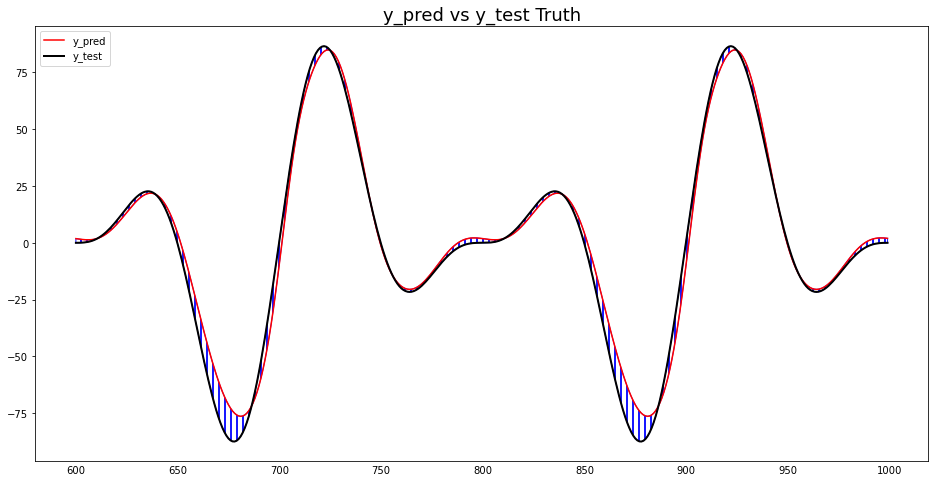

In [15]:
# Visualize the data
train = df[:training_data_length]; 
valid = df[training_data_length:]
valid.insert(1, "y_pred", y_pred, True)
fig, ax1 = plt.subplots(figsize=(16, 8), sharex=True)
xt = valid.index; yt = train[["valid"]]
xv = valid.index; yv = valid[["valid", "y_pred"]]
ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
plt.title("y_pred vs y_test Truth", fontsize=18)
plt.plot(yv["y_pred"], color="red")
plt.plot(yv["valid"], color="black", linewidth=2)
plt.legend(["y_pred", "y_test"], loc="upper left")

# Fill between plotlines
mpl.rc('hatch', color='k', linewidth=2)
ax1.fill_between(xv, yv["valid"], yv["y_pred"],  facecolor = 'white', hatch="||",  edgecolor="blue", alpha=.9) 
plt.show()

# Step #4 Measure Performance

In [19]:
y_pred = yv["y_pred"]
y_test = yv["valid"]
print(y_test.shape, y_pred.shape)

# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test, y_pred)/ y_test))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test, y_pred)/ y_test))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

(400,) (400,)
Mean Absolute Error (MAE): 4.02
Median Absolute Error (MedAE): 2.1
Mean Squared Error (MSE): 34.95
Root Mean Squared Error (RMSE): 5.91
Mean Absolute Percentage Error (MAPE): 15436.45 %
Median Absolute Percentage Error (MDAPE): 12.15 %
